In [ ]:
!pip install bs4
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import requests
from bs4 import BeautifulSoup
import time

You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
# Start writing code here...
df = pd.read_csv('Best_2000s.csv')
hdf = df.head(10)
hdf

,Unnamed: 0,Number,Title_URL,Title,Author,minirating,num_reviews,num_pages,awards,genres,series,year_published,places
0,0,1,https://www.goodreads.com/book/show/136251.Har...,Harry Potter and the Deathly Hallows (Harry Po...,J.K. Rowling,"4.62 avg rating — 2,883,079 ratings",66759,759,['Locus Award Nominee for Best Young Adult Nov...,"['Fantasy', 'Young Adult', 'Fiction']",True,2007,"London, England Hogwarts School of Witchcraft ..."
1,1,2,https://www.goodreads.com/book/show/2767052-th...,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins,"4.33 avg rating — 6,531,961 ratings",173696,374,['Locus Award Nominee for Best Young Adult Boo...,"['Young Adult', 'Fiction', 'Science Fiction']",True,2008,"District 12, Panem Capitol, Panem Panem (Unite..."
2,2,3,https://www.goodreads.com/book/show/1.Harry_Po...,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling,"4.57 avg rating — 2,506,015 ratings",40523,652,['Locus Award Nominee for Best Young Adult Nov...,"['Fantasy', 'Young Adult', 'Fiction']",True,2006,Hogwarts School of Witchcraft and Wizardry (Un...
3,3,4,https://www.goodreads.com/book/show/6.Harry_Po...,Harry Potter and the Goblet of Fire (Harry Pot...,J.K. Rowling,"4.56 avg rating — 2,671,368 ratings",47861,734,"['Hugo Award for Best Novel (2001)', "" Mythopo...","['Fantasy', 'Young Adult', 'Fiction']",True,2002,"London, England, 1994 Hogwarts School of ..."
4,4,5,https://www.goodreads.com/book/show/2.Harry_Po...,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling,"4.50 avg rating — 2,580,928 ratings",43636,870,['Bram Stoker Award for Works for Young Reader...,"['Fantasy', 'Young Adult', 'Fiction']",True,2004,Hogwarts School of Witchcraft and Wizardry (Un...
5,5,6,https://www.goodreads.com/book/show/19063.The_...,The Book Thief,Markus Zusak,"4.37 avg rating — 1,887,365 ratings",114588,552,['National Jewish Book Award for Children’s an...,"['Historical', 'Historical Fiction', 'Fiction']",False,2006,"Molching, 1939 (Germany) Germany"
6,6,7,https://www.goodreads.com/book/show/18619684-t...,The Time Traveler's Wife,Audrey Niffenegger,"3.98 avg rating — 1,599,151 ratings",47612,500,"['Arthur C. Clarke Award Nominee (2005)', ' Or...","['Fiction', 'Romance', 'Fantasy']",False,2013,"Chicago, Illinois (United States) Illinois (Un..."
7,7,8,https://www.goodreads.com/book/show/77203.The_...,The Kite Runner,Khaled Hosseini,"4.31 avg rating — 2,482,594 ratings",74898,371,['Borders Original Voices Award for Fiction (2...,"['Fiction', 'Historical', 'Historical Fiction']",False,2004,"Kabul (Afghanistan) Fremont, California (Unite..."
8,8,9,https://www.goodreads.com/book/show/4667024-th...,The Help,Kathryn Stockett,"4.46 avg rating — 2,217,788 ratings",85060,451,['Orange Prize Nominee for Fiction Longlist (2...,"['Fiction', 'Historical', 'Historical Fiction']",False,2009,"Jackson, Mississippi, 1962 (United States) Jac..."
9,9,10,https://www.goodreads.com/book/show/128029.A_T...,A Thousand Splendid Suns,Khaled Hosseini,"4.38 avg rating — 1,179,312 ratings",55175,372,['British Book Award for Best Read of the Year...,"['Fiction', 'Historical', 'Historical Fiction']",False,2007,Afghanistan Kabul (Afghanistan) Herat (Afghani...


# Data cleaning and Adding new columns

In [ ]:
## parse minirating column to get avg_rating and num_ratings
df['avg_rating'] = df['minirating'].apply(lambda x: (x.split('— ')[0]))
df['avg_rating'] = df['avg_rating'].apply(lambda x: x.replace(' avg rating', ''))
df['avg_rating'] = df['avg_rating'].apply(lambda x: x.replace(' ', '').replace('reallylikedit', '').strip())
df['num_ratings'] = df['minirating'].apply(lambda x: (x.split('— ')[1]))
df['num_ratings'] = df['num_ratings'].apply(lambda x: x.replace(' ratings', '').replace(',',''))

df = df.replace('-', np.nan)
df.drop('minirating', inplace=True, axis=1)
df.drop(['Unnamed: 0', 'Number'], axis=1, inplace=True)
   
## create awards_count
df['awards'] = df['awards'].astype(str)
awa_split = df['awards'].apply(lambda x:x.split(","))
awa_count = awa_split.apply(lambda x:len(x))
df['awards_count'] = awa_count

In [ ]:
df.isnull().sum()

Title_URL           0
Title               0
Author              0
num_reviews         0
num_pages           5
awards              0
genres              0
series              3
year_published      4
places            335
avg_rating          0
num_ratings         0
awards_count        0
dtype: int64

# Preprocessing

In [ ]:
df['avg_rating'] = df['avg_rating'].apply(lambda x: float(x))
df['num_ratings'] = df['num_ratings'].apply(lambda x: int(x))
df['num_pages'] = df['num_pages'].apply(lambda x: int(x) if x is not np.nan else np.nan) 

# normalization 1 - 10
scaler = MinMaxScaler((1, 10))
df['minmax_norm_rating'] = scaler.fit_transform(df[['avg_rating']])
df['mean_norm_ratings'] = 1 + (df['avg_rating'] - df['avg_rating'].mean()) / (df['avg_rating'].max() - df['avg_rating'].min()) * 9

# rounding the values
df['minmax_norm_rating'] = df['minmax_norm_rating'].apply(lambda x:round(x, 2))
df['mean_norm_ratings'] = df['mean_norm_ratings'].apply(lambda x:round(x,2))

# Analysis

In [ ]:
def get_info(authorName, df):
    authorData = df[df['Author']==authorName]
    authorInfo = authorData[authorData.minmax_norm_rating == authorData.minmax_norm_rating.max()]
    return authorInfo


In [ ]:
dda = get_info('J.K. Rowling', df.head(10))
dda

,Title_URL,Title,Author,num_reviews,num_pages,awards,genres,series,year_published,places,avg_rating,num_ratings,awards_count,minmax_norm_rating,mean_norm_ratings
0,https://www.goodreads.com/book/show/136251.Har...,Harry Potter and the Deathly Hallows (Harry Po...,J.K. Rowling,66759,759.0,['Locus Award Nominee for Best Young Adult Nov...,"['Fantasy', 'Young Adult', 'Fiction']",True,2007,"London, England Hogwarts School of Witchcraft ...",4.62,2883079,7,9.01,4.37


In [ ]:
groupby_minmax = df.groupby('year_published')['minmax_norm_rating'].agg('mean')
groupby_minmax

year_published
1998    6.180000
1999    5.030000
2000    5.270833
2001    5.511111
2002    5.670980
2003    5.385211
2004    5.610306
2005    5.608506
2006    5.575245
2007    5.540263
2008    5.817459
2009    5.752821
2010    5.705556
2011    6.295000
2012    5.693333
2013    5.905000
2014    5.840000
2015    7.470000
2016    5.655000
2017    6.930000
2018    6.650000
Name: minmax_norm_rating, dtype: float64

In [ ]:
df.columns

Index(['Title_URL', 'Title', 'Author', 'num_reviews', 'num_pages', 'awards',
       'genres', 'series', 'year_published', 'places', 'avg_rating',
       'num_ratings', 'awards_count', 'minmax_norm_rating',
       'mean_norm_ratings'],
      dtype='object')

# Visualization

### 1. Create a 2D scatterplot with `pages` on the x-axis and `num_ratings` on the y-axis.

Text(0.5, 1.0, '2D Scatter plot for pages and ratings')

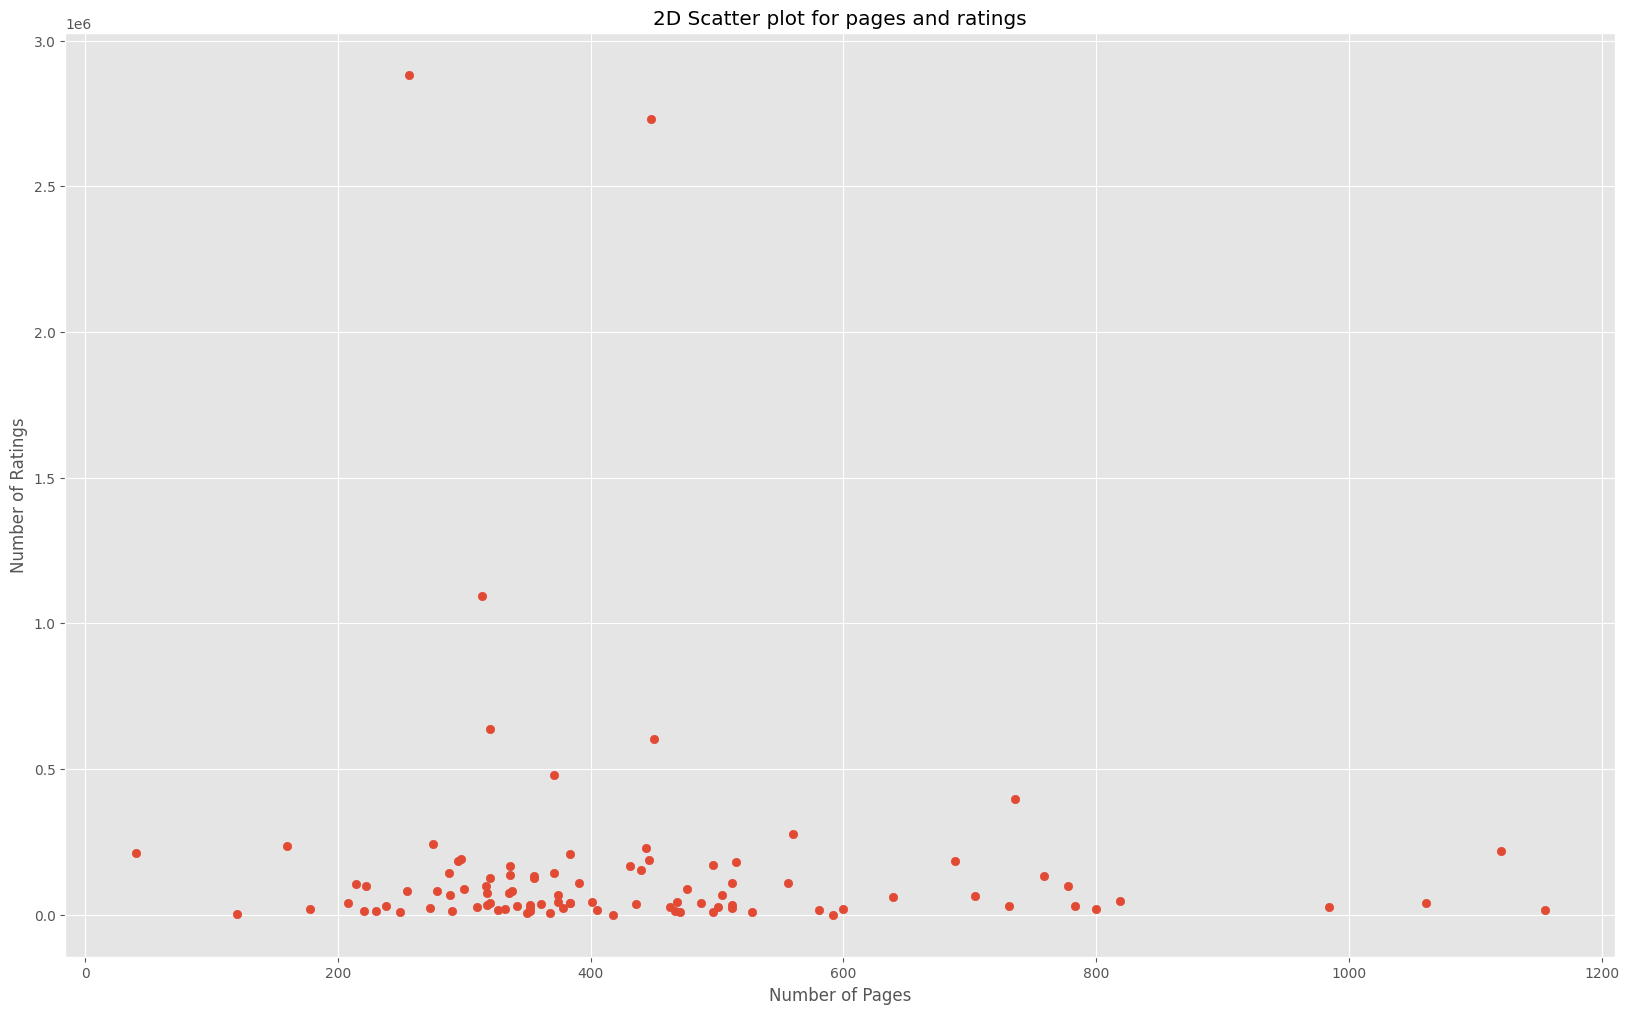

In [ ]:
#1. Create a 2D scatterplot with `pages` on the x-axis and `num_ratings` on the y-axis.
import matplotlib.pyplot as plt
df = df.sample(n = 100)
number_of_pages = df.num_pages.sort_values()
number_of_ratings = df.num_ratings 
pnr = plt.figure(figsize=(20,12))
pnr = plt.scatter(number_of_pages,number_of_ratings)
pnr = plt.xlabel('Number of Pages')
pnr = plt.ylabel('Number of Ratings')
pnr = plt.yticks()
pnr = plt.title('2D Scatter plot for pages and ratings')
pnr

### 2. Can you compute numerically the correlation coefficient of these two columns?

In [ ]:
df.isnull().sum()

Title_URL              0
Title                  0
Author                 0
num_reviews            0
num_pages              2
awards                 0
genres                 0
series                 0
year_published         1
places                47
avg_rating             0
num_ratings            0
awards_count           0
minmax_norm_rating     0
mean_norm_ratings      0
dtype: int64

In [ ]:
def correlation(col_1, col_2):
    corr = col_1.corr(col_2)
    return corr

correlation(df['avg_rating'], df['num_ratings'])

0.19193524893318495

In [ ]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,num_reviews,num_pages,avg_rating,num_ratings,awards_count,minmax_norm_rating,mean_norm_ratings
num_reviews,1.000000,0.153635,0.217905,0.814020,0.342791,0.218195,0.217663
num_pages,0.153635,1.000000,0.286830,0.249715,-0.031937,0.286651,0.286928
avg_rating,0.217905,0.286830,1.000000,0.191935,0.162024,0.999998,0.999997
num_ratings,0.814020,0.249715,0.191935,1.000000,0.130819,0.192296,0.191581
awards_count,0.342791,-0.031937,0.162024,0.130819,1.000000,0.161883,0.162121
minmax_norm_rating,0.218195,0.286651,0.999998,0.192296,0.161883,1.000000,0.999993
mean_norm_ratings,0.217663,0.286928,0.999997,0.191581,0.162121,0.999993,1.000000


### 3. Visualise the `avg_rating` distribution.

Text(0.5, 1.0, 'Average rating Distribution')

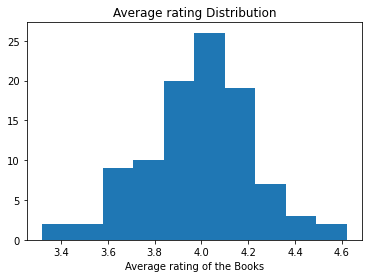

In [ ]:
#3. Visualise the `avg_rating` distribution.
df.sample(n = 1000,replace = True)
average_rating = df.avg_rating
#plt.bar(average_rating,height = 5,width=0.09,align='center')
plt.hist(average_rating)
plt.xlabel('Average rating of the Books')
plt.title('Average rating Distribution')

### 4. Visualise the `minmax_norm_rating` distribution.

Text(0.5, 1.0, 'Minmax_norm rating distribution')

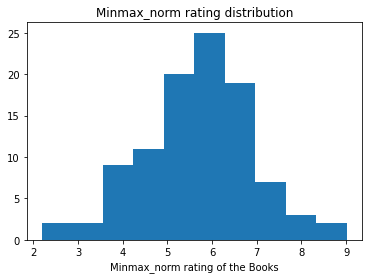

In [ ]:
#4. Visualise the `minmax_norm_rating` distribution.
min_max_norm_rating = df.minmax_norm_rating
#plt.bar(min_max_norm_rating,height = 5,width=0.5,align = 'center')
plt.hist(min_max_norm_rating)
plt.xlabel('Minmax_norm rating of the Books')
plt.title('Minmax_norm rating distribution')

### 5. Visualise the `mean_norm_rating` distribution.

Text(0.5, 1.0, 'Mean_norm rating distribution')

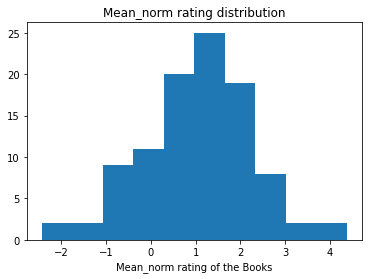

In [ ]:
#5. Visualise the `mean_norm_rating` distribution.
mean_norm_rating = df.mean_norm_ratings
#plt.bar(mean_norm_rating,height = 5,width=0.5,align = 'center')
plt.hist(mean_norm_rating)
plt.xlabel('Mean_norm rating of the Books')
plt.title('Mean_norm rating distribution')

### 6. Create one graph that represents in the same figure both minmax_norm_rating and mean_norm_rating distributions.

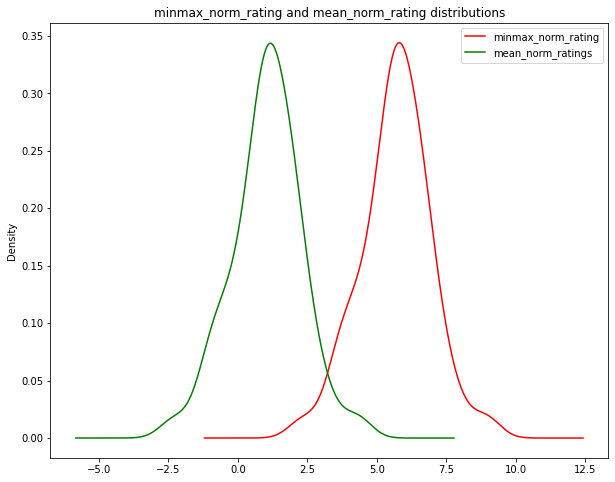

In [ ]:
## 6. 
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
df.minmax_norm_rating.plot(kind='kde', ax=ax, color='red')
df.mean_norm_ratings.plot(kind='kde', ax=ax, color='green')
ax.title.set_text('minmax_norm_rating and mean_norm_rating distributions')
ax.legend()

{'whiskers': [<matplotlib.lines.Line2D at 0x7f82afa94490>,
 'caps': [<matplotlib.lines.Line2D at 0x7f82afa94d10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f82afa940d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f82afaa0610>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f82afa8cf50>],
 'means': []}

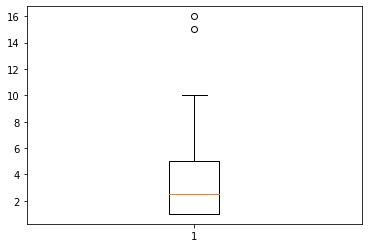

In [ ]:
#8. Visualize the `awards` distribution in a **boxplot** and **aggregtated bars**.
#Decide which of these representations gives us more information and in which cases they should be used.
plt.boxplot(df.awards_count)

Text(0.5, 1.0, 'Awards distribution')

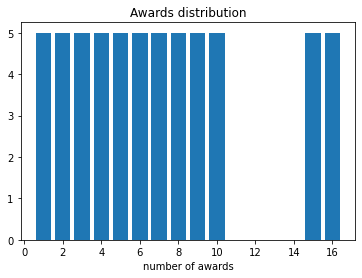

In [ ]:
#8. Visualize the `awards` distribution in a **boxplot** and **aggregtated bars**.
#Decide which of these representations gives us more information and in which cases they should be used.
plt.bar(df.awards_count,height = 5)
plt.xlabel('number of awards')
plt.title('Awards distribution')

Text(0, 0.5, 'Awards won by a book')

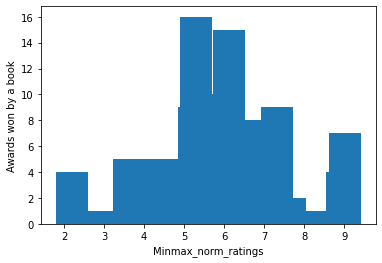

In [ ]:
# 10. Is there another representation that displays this in a more clear manner?
plt.bar(df.minmax_norm_rating,df.awards_count)
plt.xlabel('Minmax_norm_ratings')
plt.ylabel('Awards won by a book')

## 7. What is the best fit in terms of a distribution (normal, chi-squared...) to represent each of those graphs? 
* You can use Scipy-Stats Library to figure out the best fitting distribution like in this example.

In [ ]:
%matplotlib nbagg
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from tqdm import tqdm
import pandas as pd

plt.style.use('ggplot')


In [ ]:
## 7. 
def fit_scipy_distributions(array, bins, plot_hist = True, plot_best_fit = True, plot_all_fits = False):
    
    if plot_best_fit or plot_all_fits:
        assert plot_hist, "plot_hist must be True if setting plot_best_fit or plot_all_fits to True"
    
    # Returns un-normalised (i.e. counts) histogram
    y, x = np.histogram(np.array(array), bins=bins)
    
    # Some details about the histogram
    bin_width = x[1]-x[0]
    N = len(array)
    x_mid = (x + np.roll(x, -1))[:-1] / 2.0 # go from bin edges to bin middles
    
    # selection of available distributions
    # CHANGE THIS IF REQUIRED
    DISTRIBUTIONS = [st.alpha,st.cauchy,st.cosine,st.laplace,st.levy,st.levy_l,st.norm]

    if plot_hist:
        fig = plt.figure(figsize=(12,10))
        fig, ax = plt.subplots()
        h = ax.hist(np.array(array), bins = bins, color = 'w')

    # loop through the distributions and store the sum of squared errors
    # so we know which one eventually will have the best fit
    sses = []
    for dist in tqdm(DISTRIBUTIONS):
        name = dist.__class__.__name__[:-4]

        params = dist.fit(np.array(array))
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        pdf = dist.pdf(x_mid, loc=loc, scale=scale, *arg)
        pdf_scaled = pdf * bin_width * N # to go from pdf back to counts need to un-normalise the pdf

        sse = np.sum((y - pdf_scaled)**2)
        sses.append([sse, name])

        # Not strictly necessary to plot, but pretty patterns
        if plot_all_fits:
            ax.plot(x_mid, pdf_scaled, label = name)
    
    if plot_all_fits:
        plt.legend(loc=1)

    # CHANGE THIS IF REQUIRED
    ax.set_xlabel('x label')
    ax.set_ylabel('y label')

    # Things to return - df of SSE and distribution name, the best distribution and its parameters
    results = pd.DataFrame(sses, columns = ['SSE','distribution']).sort_values(by='SSE') 
    best_name = results.iloc[0]['distribution']
    best_dist = getattr(st, best_name)
    best_params = best_dist.fit(np.array(array))
    
    if plot_best_fit:
        new_x = np.linspace(x_mid[0] - (bin_width * 2), x_mid[-1] + (bin_width * 2), 1000)
        best_pdf = best_dist.pdf(new_x, *best_params[:-2], loc=best_params[-2], scale=best_params[-1])
        best_pdf_scaled = best_pdf * bin_width * N
        ax.plot(new_x, best_pdf_scaled, label = best_name)
        plt.legend(loc=1)
    
    if plot_hist:
        plt.show()
    
    return results, best_name, best_params

In [ ]:
df.columns

Index(['Title_URL', 'Title', 'Author', 'num_reviews', 'num_pages', 'awards',
       'genres', 'series', 'year_published', 'places', 'avg_rating',
       'num_ratings', 'awards_count', 'minmax_norm_rating',
       'mean_norm_ratings'],
      dtype='object')

#### All distributions for `num_reviews`

  0%|          | 0/7 [00:00<?, ?it/s]/opt/venv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/opt/venv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/opt/venv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
100%|██████████| 7/7 [00:00<00:00, 59.37it/s]
/opt/venv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


<Figure size 864x720 with 0 Axes>

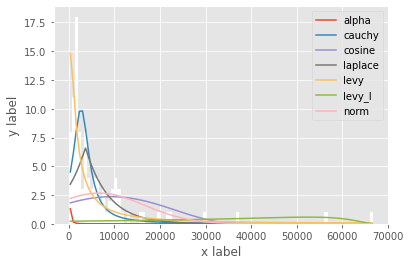

In [ ]:
num_reviews_arr = df['num_reviews'].values
sses, best_name, best_params = fit_scipy_distributions(array = num_reviews_arr, bins = 100, plot_best_fit=False, plot_all_fits=True)

#### Best distribution for `num_reviews`

100%|██████████| 7/7 [00:00<00:00, 63.12it/s]


<Figure size 864x720 with 0 Axes>

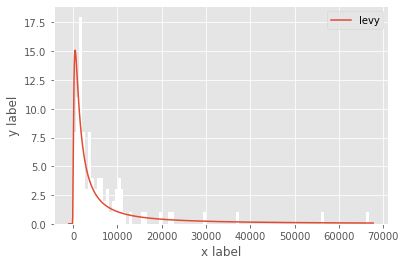

In [ ]:
sses, best_name, best_params = fit_scipy_distributions(array = num_reviews_arr, bins = 100)

#### All distributions for `minmax_norm_rating` 

  0%|          | 0/7 [00:00<?, ?it/s]/opt/venv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/opt/venv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/opt/venv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
100%|██████████| 7/7 [00:00<00:00, 67.22it/s]


<Figure size 864x720 with 0 Axes>

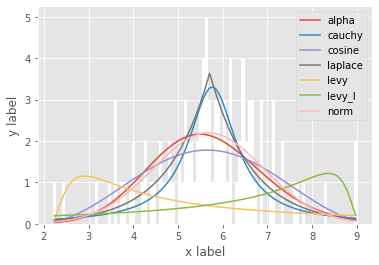

In [ ]:
# 7. minmax_norm_rating all distributions
df['minmax_norm_rating'] = df['minmax_norm_rating'].fillna(0)
minmax_norm_rating_arr = df['minmax_norm_rating'].values
sses, best_name, best_params = fit_scipy_distributions(array = minmax_norm_rating_arr, bins = 100, plot_best_fit=False, plot_all_fits=True)

#### Best distribution for `minmax_norm_rating` 

  0%|          | 0/7 [00:00<?, ?it/s]/opt/venv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
100%|██████████| 7/7 [00:00<00:00, 70.15it/s]


<Figure size 864x720 with 0 Axes>

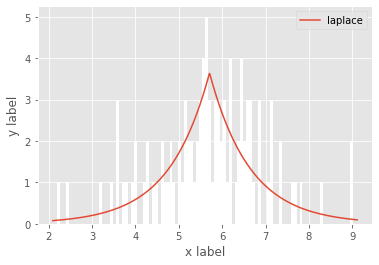

In [ ]:
sses, best_name, best_params = fit_scipy_distributions(array = minmax_norm_rating_arr, bins = 100)

In [ ]:
df.columns

Index(['Title_URL', 'Title', 'Author', 'num_reviews', 'num_pages', 'awards',
       'genres', 'series', 'year_published', 'places', 'avg_rating',
       'num_ratings', 'awards_count', 'minmax_norm_rating',
       'mean_norm_ratings'],
      dtype='object')

#### All distribition for `mean_norm_ratings`

  0%|          | 0/7 [00:00<?, ?it/s]/opt/venv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
 43%|████▎     | 3/7 [00:00<00:00, 26.72it/s]/opt/venv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/opt/venv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
100%|██████████| 7/7 [00:00<00:00, 50.18it/s]


<Figure size 864x720 with 0 Axes>

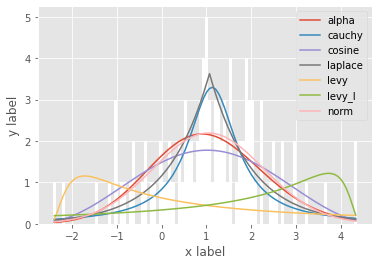

In [ ]:
# minmax_norm_rating all distributions
df['mean_norm_ratings'] = df['mean_norm_ratings'].fillna(0)
mean_norm_rating_arr = df['mean_norm_ratings'].values
sses, best_name, best_params = fit_scipy_distributions(array = mean_norm_rating_arr, bins = 100, plot_best_fit=False, plot_all_fits=True)

### 9. 
* Group the books by `original_publish_year` and get the mean of the `minmax_norm_ratings` of the groups.
* Now, make a **simple plot** to visualise the ratings w.r.t. the years!

In [ ]:
# 9. 
# "Group the books by `original_publish_year` and get the mean of the `minmax_norm_ratings` of the groups."
# Now, make a **simple plot** to visualise the ratings w.r.t. the years!

groupby_year = df.groupby(['Title','year_published']).agg({'minmax_norm_rating':'mean'})
groupby_year

,,minmax_norm_rating
Title,year_published,
"A Feast for Crows (A Song of Ice and Fire, #4)",2011,6.49
A Man Without a Country,2007,6.18
A Million Little Pieces,2005,3.93
"Airborn (Matt Cruse, #1)",2005,6.65
"Angels & Demons (Robert Langdon, #1)",2006,5.29
...,...,...
"Vampire Academy Collection (Vampire Academy, #1-3)",2009,8.95
Wesley the Owl: The Remarkable Love Story of an Owl and His Girl,2008,6.39
Wintergirls,2009,5.60


### 10. Make a scatterplot to represent  `minmax_norm_ratings` in function of the number of awards won by the book.
    - Is there another representation that displays this in a more clear manner?
    - Optional: Can you plot a best fit linear regression line to represent the relationship?  

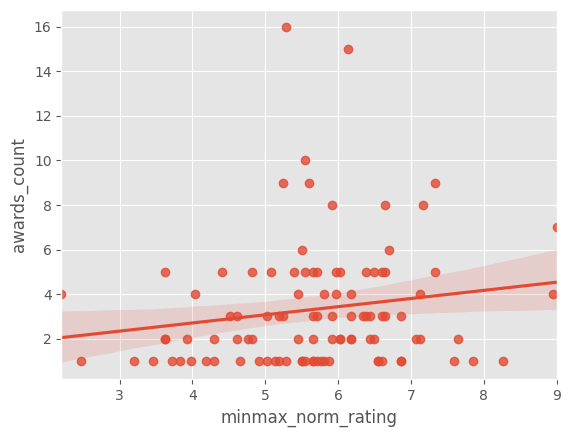

In [ ]:
sns.regplot(x="minmax_norm_rating", y="awards_count", data=df);


In [ ]:
from sklearn.linear_model import LinearRegression
df['minmax_norm_rating'] = df['minmax_norm_rating'].fillna(0)
X = df['minmax_norm_rating'].values.reshape(-1,1)
y = df['awards_count'].values
print(f"X.shape = {X.shape}")
print(f"y.shape = {y.shape}\n=========================")

# Train and Predict using linear regression

lin_reg = LinearRegression()
model_linreg = lin_reg.fit(X,y)
print("The linear regression coefficient can be accessed in a form of class attribute with model.coef_")
print("model coefficient = ", model_linreg.coef_,"\n==================================")
print("The y-intercept can be accessed in a form of class attribute with model.intercept_")
print(f"y-intercept = {model_linreg.intercept_}\n================================" )
y_prediction = model_linreg.predict(X)

# Evaluate
r2 = model_linreg.score(X,y)
print(f"R-squared = {r2}")

X.shape = (100, 1)
y.shape = (100,)
The linear regression coefficient can be accessed in a form of class attribute with model.coef_
model coefficient =  [0.36559998] 
The y-intercept can be accessed in a form of class attribute with model.intercept_
y-intercept = 1.24262436378145
R-squared = 0.026206020393974683


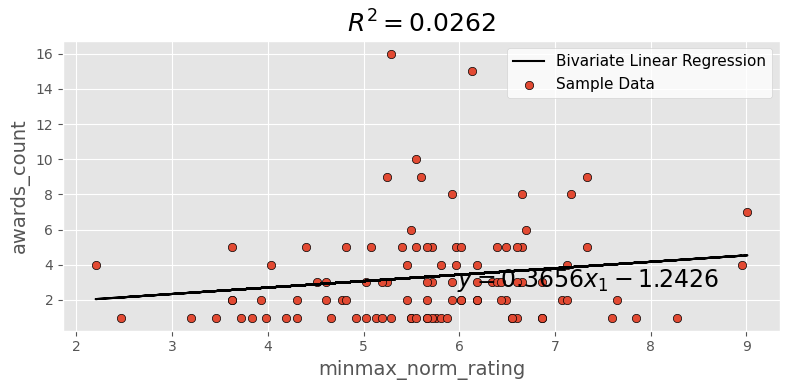

In [ ]:
# Plot 
plt.style.use('default')
plt.style.use('ggplot')
fig,ax = plt.subplots(figsize=(8,4))
ax.plot(X, y_prediction, color='k', label='Bivariate Linear Regression')
ax.scatter(X,y, edgecolor='k', label='Sample Data')
ax.set_ylabel('awards_count', fontsize=14)
ax.set_xlabel('minmax_norm_rating', fontsize=14)
ax.text(0.8,0.1,'', fontsize=13, ha='center', va='center', 
        transform=ax.transAxes, color='gray')
ax.legend(facecolor='white', fontsize=11)
ax.set_title('$R^2= %.4f$' % r2, fontsize=18)
ax.text(0.55, 0.15, '$y = %.4f x_1 - %.4f $' % (model_linreg.coef_[0], abs(model_linreg.intercept_)), fontsize=17, transform=ax.transAxes)

fig.tight_layout()

##  `minmax_norm_rating` is able to explain only 2% of data-points when compared to target feature